In [1]:
from cmb.configs.utils import Configs
from cmb.datasets.jetclass import JetDataclass

config = Configs('epic_cmb.yaml') 
jets = JetDataclass(config.data, task='train')

INFO: created experiment instance GaussNoise_to_JetClass_FlowMatching_TelegraphProcess_HybridEPiC_2024.11.03_07h43_3050


/home/df630/CMB/src/cmb/datasets/utils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


## JetClass data

In [1]:
jets.target.display_cloud(100, savefig='qcd_cloud.png')

NameError: name 'jets' is not defined

In [8]:
(jets.target.continuous.shape, 
jets.source.continuous.shape, 
jets.target.discrete.shape,
jets.source.discrete.shape,  
jets.target.mask.shape,
jets.source.mask.shape)

(torch.Size([100000, 128, 3]),
 torch.Size([100000, 128, 3]),
 torch.Size([100000, 128, 6]),
 torch.Size([100000, 128, 6]),
 torch.Size([100000, 128, 1]),
 torch.Size([100000, 128, 1]))

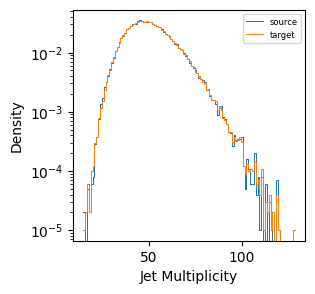

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(jets.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='source')
sns.histplot(jets.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

In [ ]:
from cmb.datasets.jetclass import JetClassHighLevelFeatures
import torch
data = JetClassHighLevelFeatures(jets.target)

from cmb.datasets.utils import flavor_to_onehot, states_to_flavor

def flavor_fracs(data: JetClassHighLevelFeatures):
    states = torch.argmax(flavor_to_onehot(data.constituents.flavor, data.constituents.charge.squeeze(-1)), dim=-1)
    mask = data.constituents.mask.squeeze(-1) > 0
    return states[mask]

flavor_fracs(data)


Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination
#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#-----------------------

Calculating N-subjettiness
Calculating D2


tensor([1, 0, 2,  ..., 0, 0, 0])

## Train CMB

In [ ]:
from cmb.models.trainers import GenerativeDynamicsModule
cmb = GenerativeDynamicsModule(config, jets)
cmb.train()


# Inference

### load trained model

In [1]:
from cmb.models.trainers import GenerativeDynamicsModule

path='/home/df630/CMB/results/runs/jetclass_generation_CMB/gauss_to_tbqq_FlowMatching_TelegraphProcess_HybridEPiC_2024.10.06_03h07_1979'
cmb = GenerativeDynamicsModule(config=path + '/config.yaml', device='cuda:0')
cmb.load(checkpoint='best')

2024-11-07 05:09:27.245138: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 05:09:29.113482: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 05:09:29.122053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 05:09:33.874954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  TelegraphProcess
      - solver method:  EulerLeapingSolver
INFO: loading `best` epoch checkpoint on cuda:0 from:
  - /home/df630/CMB/results/runs/jetclass_generation_CMB/gauss_to_tbqq_FlowMatching_TelegraphProcess_HybridEPiC_2024.10.06_03h07_1979/best_epoch.ckpt


### Generate data

In [2]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from cmb.datasets.jetclass import JetDataclass, ParticleClouds

num_jets = 100
cmb.config.pipeline.num_timesteps=1000
cmb.config.pipeline.time_eps = 0.001

test = JetDataclass(cmb.config.data, task='test', num_jets=num_jets)
test.source.preprocess(output_continuous=cmb.config.data.preprocess.continuous,
                       output_discrete=cmb.config.data.preprocess.discrete)

cmb.generate(source_continuous=test.source.continuous, 
             source_discrete=test.source.discrete,
             mask=test.source.mask,
             dataclass = ParticleClouds,
             output_history=True,
            #  save_to='sample'
             )    

/home/df630/CMB/src/cmb/datasets/utils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


INFO: generating samples...


batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap, BoundaryNorm


def plot_trajectories(paths, jumps, timesteps=[0, 0.2, 0.4, 0.6, 0.8, 1.0], title='CMB'cmap='tab10', show_paths=False):
    """ Plot trajectories of some selected samples.
    """

    paths.shape[0]
    _, ax = plt.subplots(1, len(timesteps), figsize=(2.4*len(timesteps), 2.75))

    for j, time in enumerate(timesteps):

        idx_path = int(time * len(paths)) if time < 1 else -1 
        vmin, vmax = jumps.min(), jumps.max()
        
        if show_paths:
            for i in range(N):
                ax[j].plot(paths[:idx_path, i, 0], paths[:idx_path, i, 1], alpha=0.3, lw=0.1, color='k')  # Plot lines for each trajectory

        ax[j].scatter(paths[0, :N, 0], paths[0, :N, 1], s=1, color='gray', alpha=0.2, vmin=vmin, vmax=vmax)
        ax[j].scatter(paths[idx_path, :N, 0], paths[idx_path, :N, 1], s=1, c=jumps[idx_path, :N], cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
        ax[j].text(0.125, 0.95, f't={idx_path/len(paths) if time < 1 else 1:.1f}', horizontalalignment='center', verticalalignment='center', transform=ax[j].transAxes, fontsize=10)
        ax[j].set_xlim(-1.25, 1.25)
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].axis('equal')

    ax[0].set_title(title, fontsize=10)
    plt.tight_layout()
    plt.show()



In [14]:
cmb.trajectories[0].shape

torch.Size([100, 128, 3])

## load generated data

In [12]:
#load from npy file
import torch
from cmb.datasets.jetclass import ParticleClouds

# path='/home/df630/CMB/results/runs/jetclass_generation_CMB/gauss_to_tbqq_FlowMatching_TelegraphProcess_HybridEPiC_2024.10.06_03h07_1979'

gen_data=[]
for i in range(1,24):
    gen_data.append(torch.load(path + f'/generated_sample_{i}.pt'))

gen_data = torch.cat(gen_data, dim=0)
cmb.sample = ParticleClouds(gen_data)
cmb.sample.stats = cmb.config.data.target.train.stats 
if not isinstance(cmb.sample.stats, dict):
    cmb.sample.stats = cmb.sample.stats.to_dict()
cmb.sample.postprocess(input_continuous=cmb.config.data.preprocess.continuous, 
                        input_discrete=cmb.config.data.preprocess.discrete)

## Plot results

In [13]:
from cmb.datasets.jetclass import JetClassHighLevelFeatures

data = JetClassHighLevelFeatures(cmb.sample)
test = JetClassHighLevelFeatures(test.target)  

from cmb.datasets.utils import flavor_to_onehot, states_to_flavor

def flavor_fracs(data: JetClassHighLevelFeatures):
    states = torch.argmax(flavor_to_onehot(data.constituents.flavor, data.constituents.charge.squeeze(-1)), dim=-1)
    mask = data.constituents.mask.squeeze(-1) > 0
    return states[mask]

gen_fracs = flavor_fracs(data)
test_fracs = flavor_fracs(test)

Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination
#--------------------------------------------------------------------------
#                         FastJet release 3.4.1


#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Calculating N-subjettiness
Calculating D2
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination
Calculating N-subjettiness
Cal

In [14]:
arg_test = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, False), color='silver', lw=0.25, label='JetClass (tops)')
arg_gen = dict(stat='density', fill=False,log_scale=(False, False), color='crimson', lw=1.25,  label='Hybrid EPiC')
arg_test_log = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, True), color='silver', lw=0.25, label='JetClass (tops)')
arg_gen_log = dict(stat='density', fill=False,log_scale=(False, True), color='crimson', lw=1.25,  label='Hybrid EPiC')


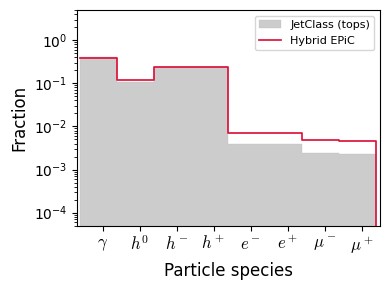

In [15]:
_, ax = plt.subplots(figsize=(4,3))                                          
sns.histplot(test_fracs, binrange=(-0.1, 7), ax=ax, element='step', discrete=True, **arg_test_log)
sns.histplot(gen_fracs, binrange=(-0.1, 7), ax=ax, element='step', discrete=True, **arg_gen_log)
ax.legend(loc='upper right', fontsize=8)
ax.set_xlabel('Particle species', fontsize=12)
ax.set_ylabel('Fraction', fontsize=12)
ax.set_xticks(np.arange(8))
ax.set_xlim(-0.7, 7.5)
ax.set_ylim(5e-5, 5)
ax.set_xticklabels([r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^-$', r'$\mu^+$'], fontsize=12)
plt.savefig(cmb.workdir / f'flavor_fracs_{cmb.config.pipeline.num_timesteps}_steps_{num_jets}_jets.png')
plt.tight_layout()
plt.show()

torch.Size([4584231])

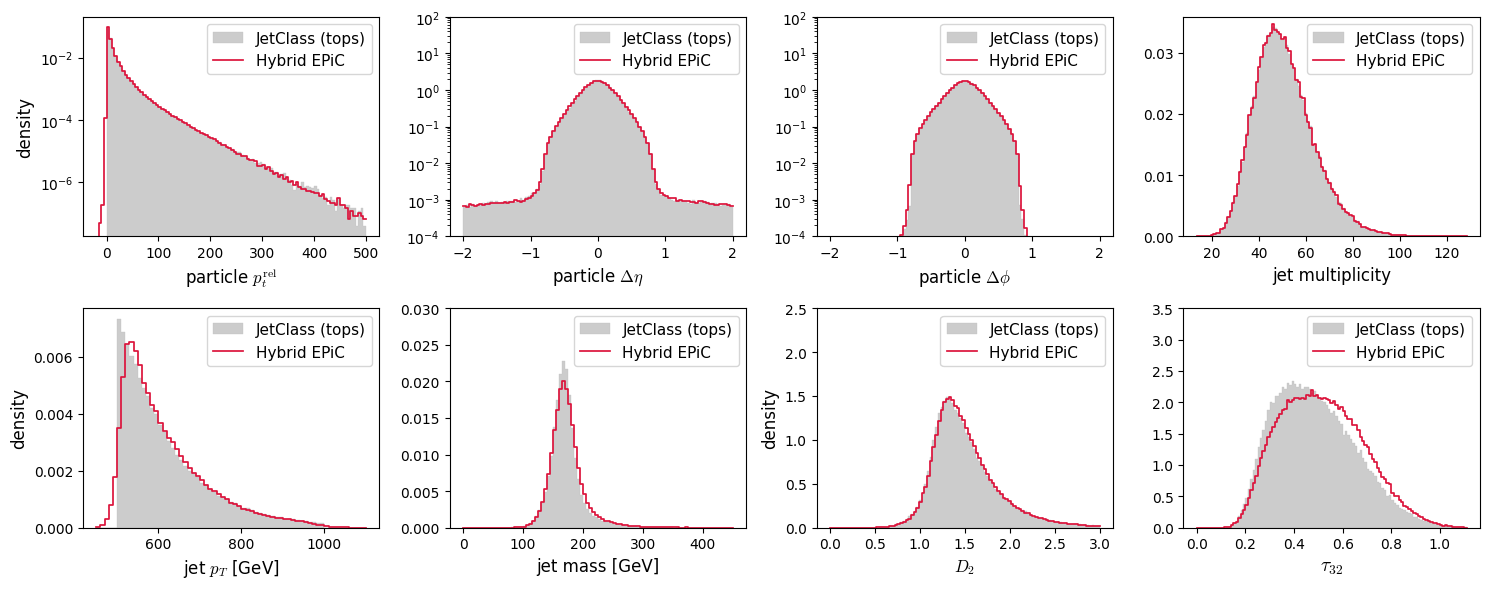

In [16]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(2,4,figsize=(15,6))

binrange, binwidth = (-20, 500), 5
test.constituents.histplot('pt', binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0,0], **arg_test_log)
data.constituents.histplot('pt', binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ylabel='density' , ax=ax[0,0], **arg_gen_log)
ax[0,0].legend(loc='upper right', fontsize=11)

binrange, binwidth, ylim = (-2, 2), 0.04, (1e-4, 100)
test.constituents.histplot('eta_rel',  ylim=ylim, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_test_log)
data.constituents.histplot('eta_rel',  ylim=ylim, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_gen_log)
ax[0,1].legend(loc='upper right', fontsize=11)

binrange, binwidth, ylim = (-2, 2), 0.04, (1e-4, 100)
test.constituents.histplot('phi_rel', ylim=ylim, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_test_log)
data.constituents.histplot('phi_rel', ylim=ylim, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_gen_log)
ax[0,2].legend(loc='upper right', fontsize=11)

test.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_test)
data.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_gen)
ax[0,3].legend(loc='upper right', fontsize=11)

# ------------------------------

binrange, binwidth = (450, 1100), 10
test.histplot('pt',  xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_test)
data.histplot('pt',  xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_gen)
ax[1,0].legend(loc='upper right', fontsize=11)

binrange, binwidth,  ylim = (0, 450), 5, (0, 0.03)
test.histplot('m',  xlabel=r'jet mass [GeV]',  ylim=ylim, ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_test)
data.histplot('m',  xlabel=r'jet mass [GeV]',  ylim=ylim, ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_gen)
ax[1,1].legend(loc='upper right', fontsize=11)

binrange, binwidth, ylim = (0, 3.0), 0.03, (0, 2.5)
test.histplot('d2',  xlabel=r'$D_2$', ylabel='density', ylim=ylim, ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_test)
data.histplot('d2',  xlabel=r'$D_2$', ylabel='density', ylim=ylim, ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_gen)
ax[1,2].legend(loc='upper right', fontsize=11)

binrange, binwidth, ylim = (0, 1.1), 0.01, (0, 3.5)
test.histplot('tau32',  xlabel=r'$\tau_{32}$',  ylim=ylim, ax=ax[1,3], binrange=binrange, binwidth=binwidth, fontsize=14, **arg_test)
data.histplot('tau32',  xlabel=r'$\tau_{32}$',  ylim=ylim, ax=ax[1,3], binrange=binrange, binwidth=binwidth, fontsize=14, **arg_gen)
ax[1,3].legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(cmb.workdir / f'features_{cmb.config.pipeline.num_timesteps}_steps_{num_jets}_jets.png')
plt.show()




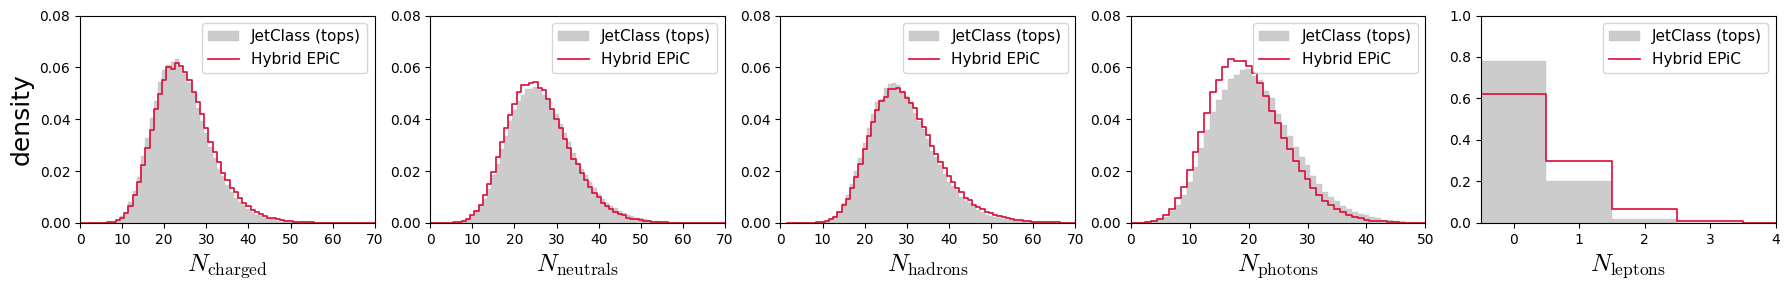

In [17]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,5,figsize=(18,3))

arg_test = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, False), color='silver', lw=0.25, label='JetClass (tops)')
arg_gen = dict(stat='density', fill=False,log_scale=(False, False), color='crimson', lw=1.25,  label='Hybrid EPiC')
arg_test_log = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, True), color='silver', lw=0.25, label='JetClass (tops)')
arg_gen_log = dict(stat='density', fill=False,log_scale=(False, True), color='crimson', lw=1.25,  label='Hybrid EPiC')

xlim, ylim = (0, 70), (0, 0.08)
test.histplot_multiplicities(state=[2,3,4], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm charged}$', ylabel='density', fontsize=18, ax=ax[0], **arg_test)
data.histplot_multiplicities(state=[2,3,4], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm charged}$', ylabel='density', fontsize=18, ax=ax[0], **arg_gen)
ax[0].legend(loc='upper right', fontsize=11)

xlim, ylim = (0, 70), (0, 0.08)
test.histplot_multiplicities(state=[0,1], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm neutrals}$', fontsize=18, ax=ax[1], **arg_test)
data.histplot_multiplicities(state=[0,1], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm neutrals}$', fontsize=18, ax=ax[1], **arg_gen)
ax[1].legend(loc='upper right', fontsize=11)

xlim, ylim = (0, 70), (0, 0.08)
test.histplot_multiplicities(state=[1,2], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm hadrons}$', fontsize=18, ax=ax[2], **arg_test)
data.histplot_multiplicities(state=[1,2], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm hadrons}$', fontsize=18, ax=ax[2], **arg_gen)
ax[2].legend(loc='upper right', fontsize=11)

xlim, ylim = (0, 50), (0, 0.08)
test.histplot_multiplicities(state=0, xlabel=r'$N_{\rm photons}$', xlim=xlim, ylim=ylim, fontsize=18, ax=ax[3], **arg_test)
data.histplot_multiplicities(state=0, xlabel=r'$N_{\rm photons}$', xlim=xlim, ylim=ylim, fontsize=18, ax=ax[3], **arg_gen)
ax[3].legend(loc='upper right', fontsize=11)

xlim, ylim = (-0.5,4), (0, 1.0)
test.histplot_multiplicities(state=[4,5], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm leptons}$', fontsize=18, ax=ax[4], **arg_test)
data.histplot_multiplicities(state=[4,5], xlim=xlim, ylim=ylim, xlabel=r'$N_{\rm leptons}$', fontsize=18, ax=ax[4], **arg_gen)
ax[4].legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(cmb.workdir / f'multiplicities_{cmb.config.pipeline.num_timesteps}_steps_{num_jets}_jets.png')
plt.show()

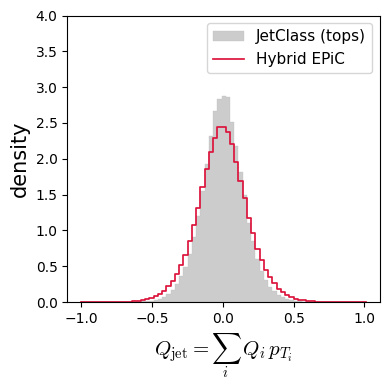

In [18]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,1,figsize=(4,4))

binrange, binwidth, ylim = (-1, 1), 0.03, (0.0, 4.0)
test.histplot('Q_jet', xlabel=r'$Q_{\rm jet} = \sum_{i} \, Q_i\, p_{T_i}$', ylabel='density',  ylim=ylim, binrange=binrange, binwidth=binwidth, fontsize=15, ax=ax, **arg_test)
data.histplot('Q_jet', xlabel=r'$Q_{\rm jet} = \sum_{i} \, Q_i\, p_{T_i}$', ylabel='density', ylim=ylim, binrange=binrange, binwidth=binwidth, fontsize=15, ax=ax, **arg_gen)
ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(cmb.workdir / f'multiplicities_{cmb.config.pipeline.num_timesteps}_steps_{num_jets}_jets.png')
plt.show()

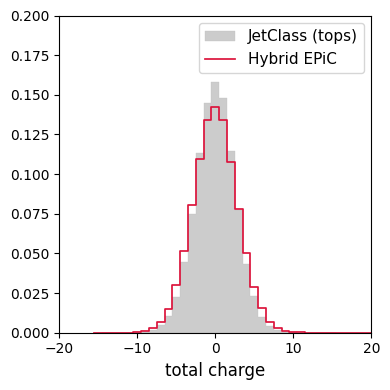

In [19]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,1,figsize=(4,4))

xlim, ylim = (-20, 20), (0, 0.2)
test.histplot('Q_total', xlabel=r'total charge', xlim=xlim, ylim=ylim,  discrete=True, ax=ax, **arg_test)
data.histplot('Q_total', xlabel=r'total charge', xlim=xlim, ylim=ylim, discrete=True, ax=ax, **arg_gen)
ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(cmb.workdir / f'multiplicities_{cmb.config.pipeline.num_timesteps}_steps_{num_jets}_jets.png')
plt.show()
